Number of fraudulent transactions: 7506
Number of non-fraudulent transactions: 1289169


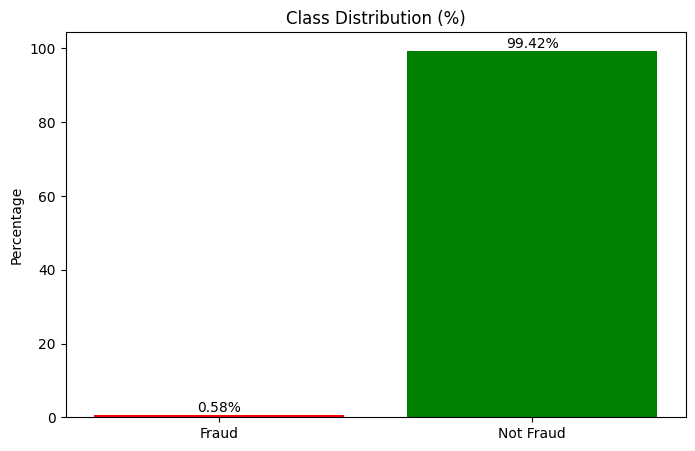

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

path = '../data/raw/fraudTrain.csv'
df = pd.read_csv(path, index_col=0)

is_fraud = 0
is_not_fraud = 0

for col in df['is_fraud']:
    if col == 1:
        is_fraud += 1
    else:
        is_not_fraud += 1


print(f"Number of fraudulent transactions: {is_fraud}")
print(f"Number of non-fraudulent transactions: {is_not_fraud}")

labels = ['Fraud', 'Not Fraud']
values = [is_fraud, is_not_fraud]
total = is_fraud + is_not_fraud

fraud_percentage = (is_fraud / total) * 100
not_fraud_percentage = (is_not_fraud / total) * 100

labels = ['Fraud', 'Not Fraud']
values = [fraud_percentage, not_fraud_percentage]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=['red', 'green'])

plt.title('Class Distribution (%)')
plt.ylabel('Percentage')

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{value:.2f}%',
        ha='center',
        va='bottom'
    )

plt.show()



Observemos que la cantidad de trasacciones fraudulentas son muy insignificante al lado de las trasancciones normales. Por lo tanto el dataset esta altamente desbalanceado. Esto quiere decir que no podemos realizar un modelo simple que indique si tenemos una trasacciones fraudulenta o no, ya que siempre va predecir que no lo es, lo cual nos llevaria a tener un modelo inutil, sin practicamente informacion de la cual aprender.


Aca entra SMOTE (Synthetic Minority Over-sampling Technique):

¿Qué hace? En lugar de simplemente duplicar las filas de fraude existentes, SMOTE mira los puntos de fraude en el espacio multidimensional y crea nuevos puntos sintéticos en el medio de ellos.

Resultado: Inventa datos de fraude "verosímiles" para que tu modelo de Sklearn (como un Random Forest) tenga suficientes ejemplos para aprender los patrones del robo.

In [5]:
#Drop list of columns with redundant information

columns_to_drop = ['trans_num','cc_num','first', 'last', 'street', 'unix_time']
try:
    df_processed = df.drop(columns=columns_to_drop)
    print("Successfully dropped columns")

    df_processed.to_csv('../data/processed/fraudTrainProcessed.csv', index=False)
    print("Successfully created CSV file")
except KeyError as e:
    print(f"Error: Column {e} not found in DataFrame.")
except Exception as e:
    print(f"Error processing DataFrame: {e}")

Successfully dropped columns
Successfully created CSV file


Transaction date successfully converted to datetime format


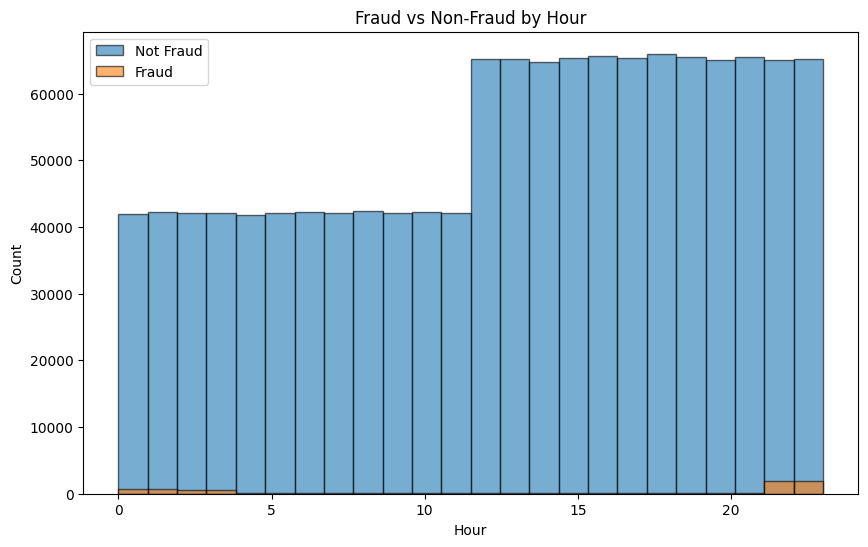

In [10]:
#Transform in datetime format
try:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    print("Transaction date successfully converted to datetime format") 

    df['hour'] = df['trans_date_trans_time'].dt.hour

# Analyze the distribution of fraudulent vs non-fraudulent transactions by hour

    fraud = df[df['is_fraud'] == 1]
    not_fraud = df[df['is_fraud'] == 0]

    plt.figure(figsize=(10,6))

    plt.hist(not_fraud['hour'], bins=24, alpha=0.6, label='Not Fraud', edgecolor='black')
    plt.hist(fraud['hour'], bins=24, alpha=0.6, label='Fraud', edgecolor='black')

    plt.legend()
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.title('Fraud vs Non-Fraud by Hour')

    plt.show()

except Exception as e:
    print(f"Error processing transaction date: {e}")
except KeyError as e:
    print(f"Error: Column {e} not found in DataFrame.")

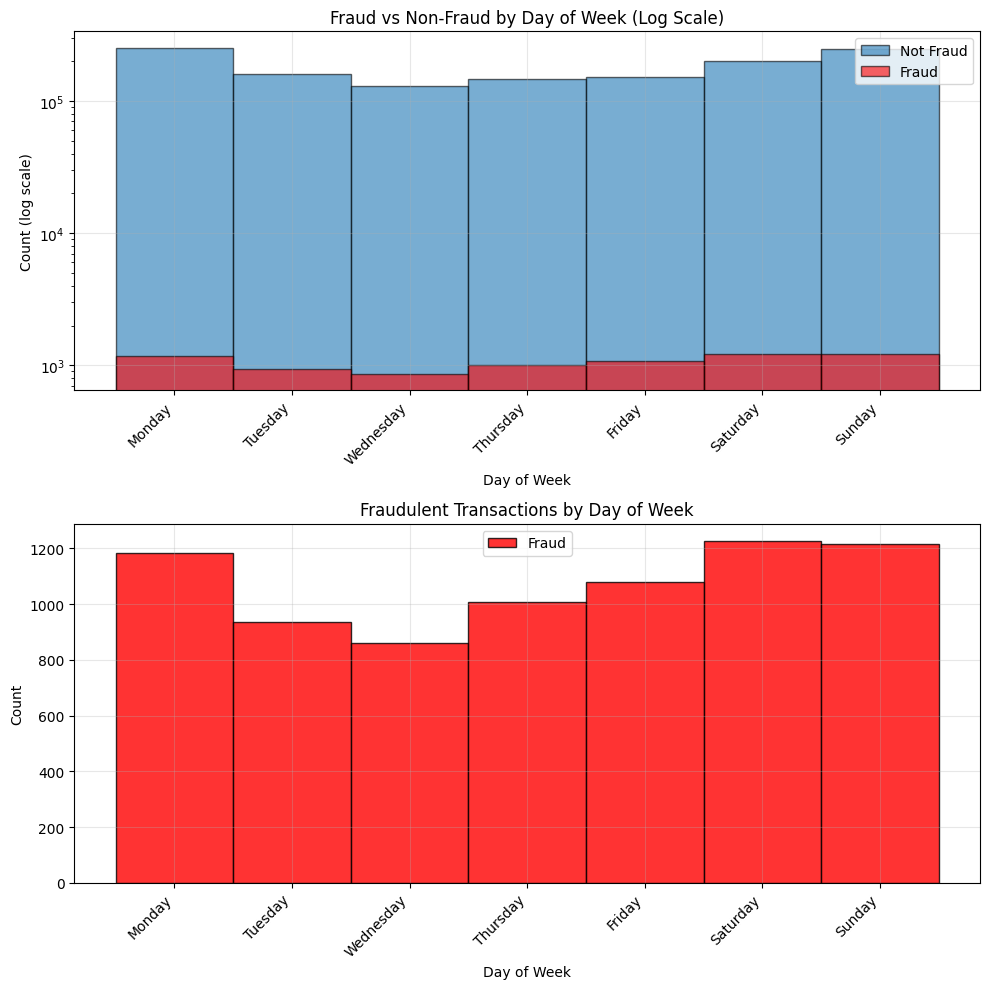

In [16]:
df['dayofweek'] = df['trans_date_trans_time'].dt.dayofweek

fraud = df[df['is_fraud'] == 1]
not_fraud = df[df['is_fraud'] == 0]

# Create figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Both distributions together with log scale
axes[0].hist(not_fraud['dayofweek'], bins=7, alpha=0.6, label='Not Fraud', edgecolor='black', range=(-0.5, 6.5))
axes[0].hist(fraud['dayofweek'], bins=7, alpha=0.6, label='Fraud', edgecolor='black', range=(-0.5, 6.5), color='red')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Count (log scale)')
axes[0].set_title('Fraud vs Non-Fraud by Day of Week (Log Scale)')
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_names, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Only fraud transactions
axes[1].hist(fraud['dayofweek'], bins=7, alpha=0.8, label='Fraud', edgecolor='black', range=(-0.5, 6.5), color='red')
axes[1].legend()
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Count')
axes[1].set_title('Fraudulent Transactions by Day of Week')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Observemos que en el grafico obtenido las horas mas en las que se realizan las transacciones fraudulentas son entre las 22PM y 3/4AM. Se estima que se realizan en esa hora por una cuestion de que los dueños de las cuentas bancarias no estan al pendiente de las notificaciones del banco o estan durmiendo. Ademas los dias en los que se realizan mas fraudes son los Lunes, Sabados y Domingos 